# Efficient Frontiner from Modern Portfolio Theory implemented in Python

In [1]:
! pip install Quandl

In [0]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import quandl
import scipy.optimize as sco

np.random.seed(777)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
quandl.ApiConfig.api_key = 'qfE2j9en-ijxfYUdH8Ew'
stocks = ['AMZN','GOOGL']
data = quandl.get_table('WIKI/PRICES', ticker = stocks,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': '2015-1-1', 'lte': '2019-12-31' }, paginate=True)
data.head()

,date,ticker,adj_close
None,,,
0,2018-03-27,GOOGL,1006.94
1,2018-03-26,GOOGL,1054.09
2,2018-03-23,GOOGL,1026.55
3,2018-03-22,GOOGL,1053.15
4,2018-03-21,GOOGL,1094.00


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1625 entries, 0 to 1624
Data columns (total 3 columns):
date         1625 non-null datetime64[ns]
ticker       1625 non-null object
adj_close    1625 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 38.2+ KB


In [5]:
df = data.set_index('date')
df.head()

,ticker,adj_close
date,,
2018-03-27,GOOGL,1006.94
2018-03-26,GOOGL,1054.09
2018-03-23,GOOGL,1026.55
2018-03-22,GOOGL,1053.15
2018-03-21,GOOGL,1094.00


In [6]:
table = df.pivot(columns='ticker')
table.columns = [col[1] for col in table.columns]
table.head()

,AMZN,GOOGL
date,,
2015-01-02,308.52,529.55
2015-01-05,302.19,519.46
2015-01-06,295.29,506.64
2015-01-07,298.42,505.15
2015-01-08,300.46,506.91


/usr/local/lib/python2.7/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0,0.5,'price in $')

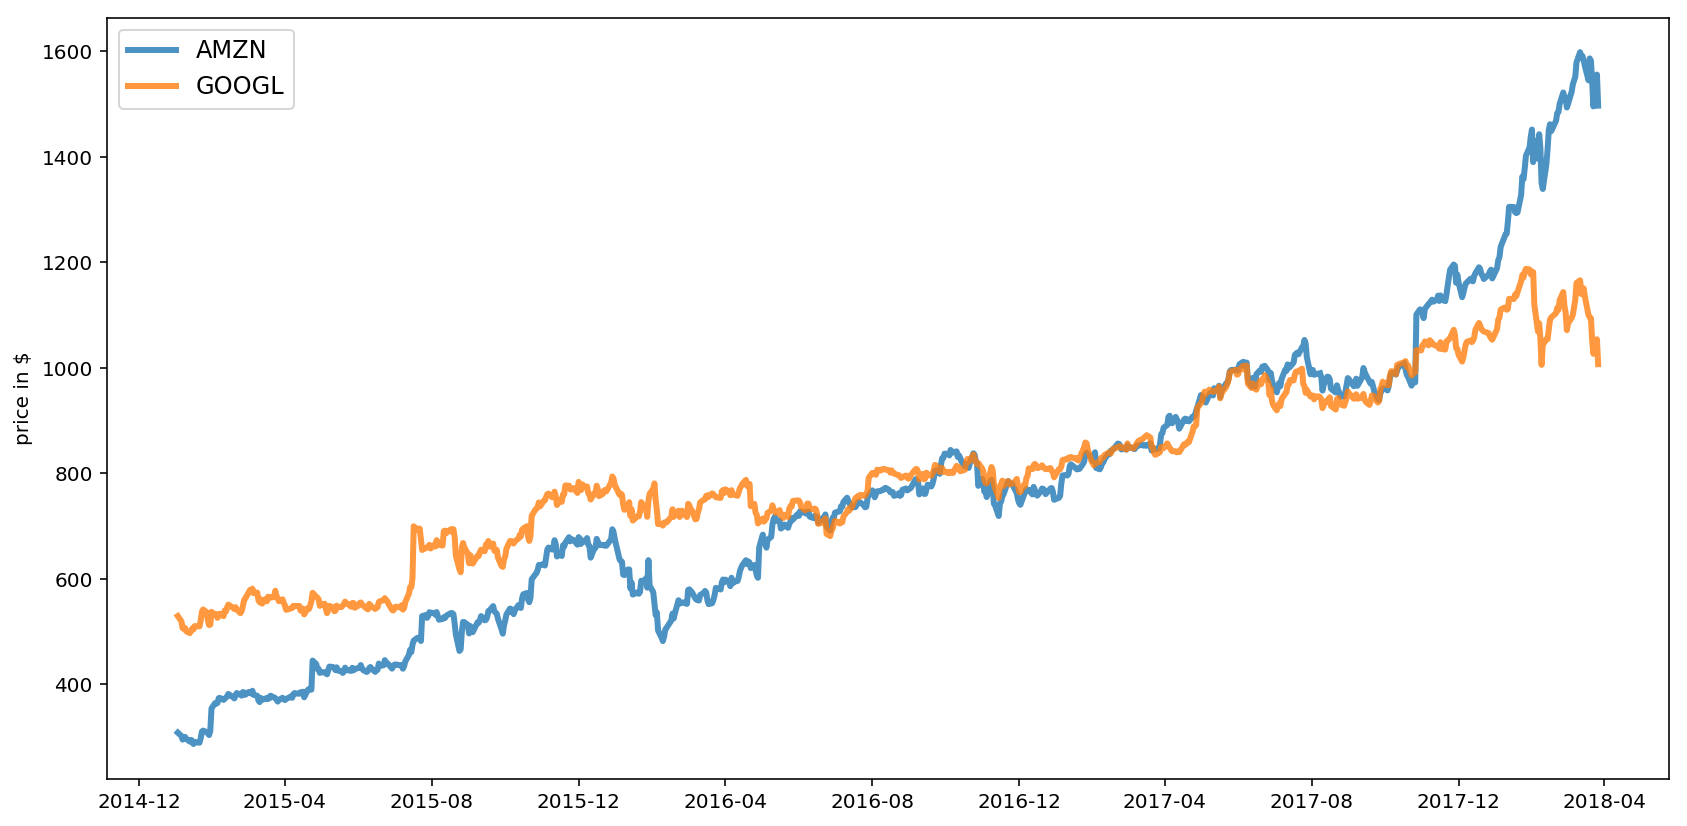

In [7]:
plt.figure(figsize=(14, 7))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

Text(0,0.5,'daily returns')

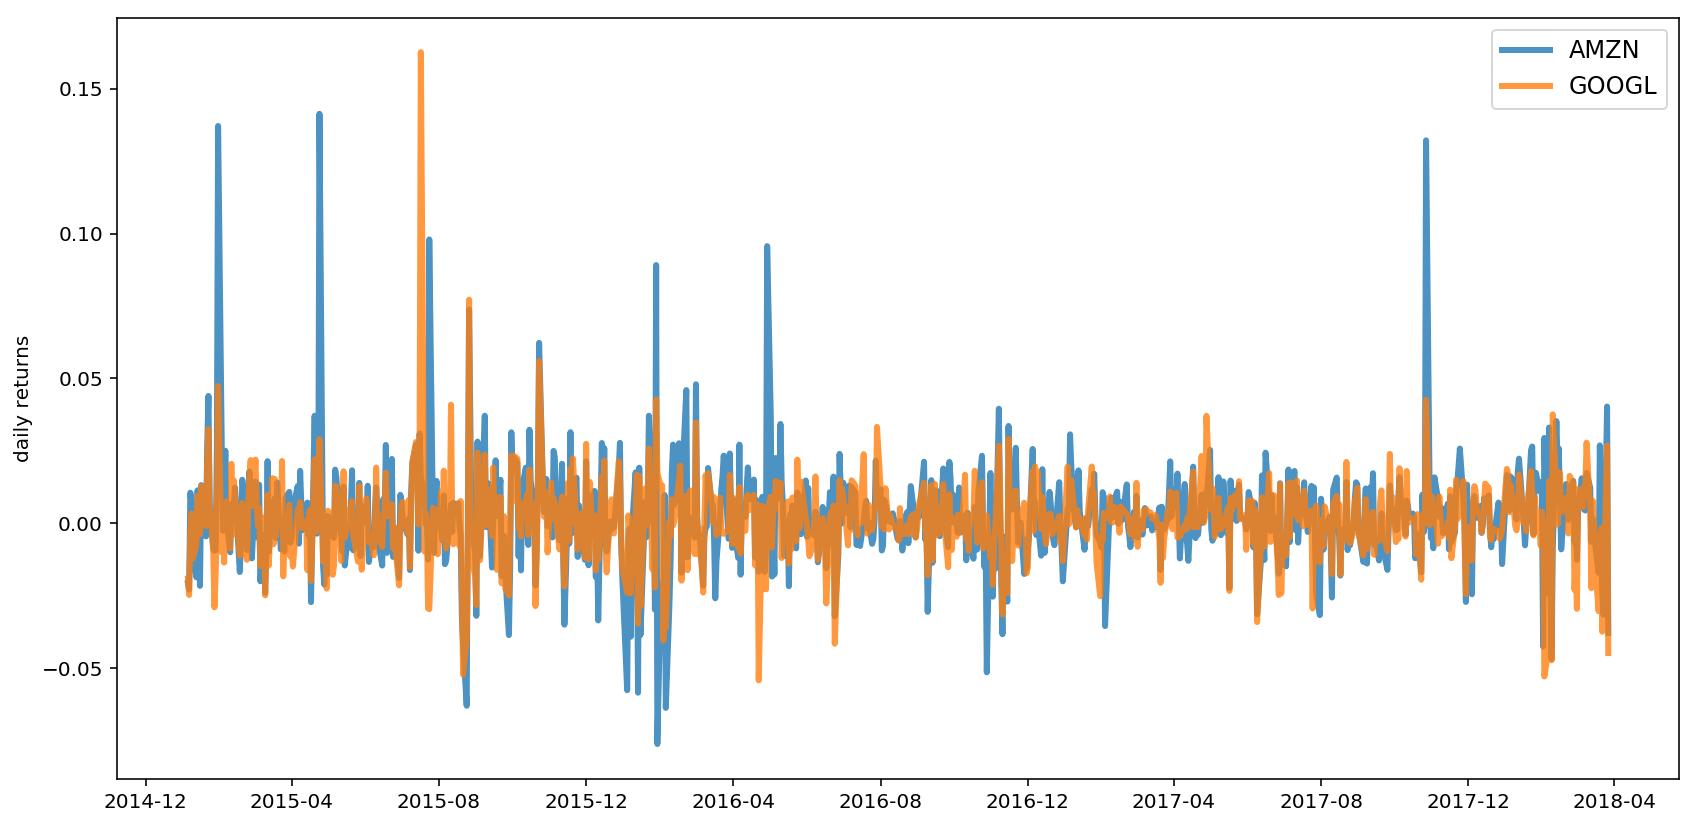

In [8]:
returns = table.pct_change()

plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

## Random Portfolios Generation

"portfolio_annual_performance" function will calculate the returns and volatility taking 252 as the number of trading days in one year. "random_portfolios" function will generate portfolios with random weights assigned to each stock, and by passing num_portfolios argument.

In [0]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [0]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in xrange(num_portfolios):
        weights = np.random.random(2)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [0]:
returns = table.pct_change() # daily returns
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.0178

The following function generates random portfolio and gets the results (portfolio returns, portfolio volatility, portfolio Sharpe ratio) and weights for the corresponding result. Then by locating the one with the highest Sharpe ratio portfolio, it displays maximum Sharpe ratio portfolio as red star sign. And does similar steps for minimum volatility portfolio, and displays it as the green star on the plot. All the randomly generated portfolios will be also plotted with colour map applied to them based on the Sharpe ratio. The bluer, the higher Sharpe ratio.

And for these two optimal portfolios, it will also show how it allocates the budget within the portfolio.

In [0]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print "-"*80
    print "Maximum Sharpe Ratio Portfolio Allocation\n"
    print "Annualised Return:", round(rp,2)
    print "Annualised Volatility:", round(sdp,2)
    print "\n"
    print max_sharpe_allocation
    print "-"*80
    print "Minimum Volatility Portfolio Allocation\n"
    print "Annualised Return:", round(rp_min,2)
    print "Annualised Volatility:", round(sdp_min,2)
    print "\n"
    print min_vol_allocation
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.53
Annualised Volatility: 0.29


             AMZN  GOOGL
allocation  100.0    0.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.3
Annualised Volatility: 0.22


             AMZN  GOOGL
allocation  23.49  76.51


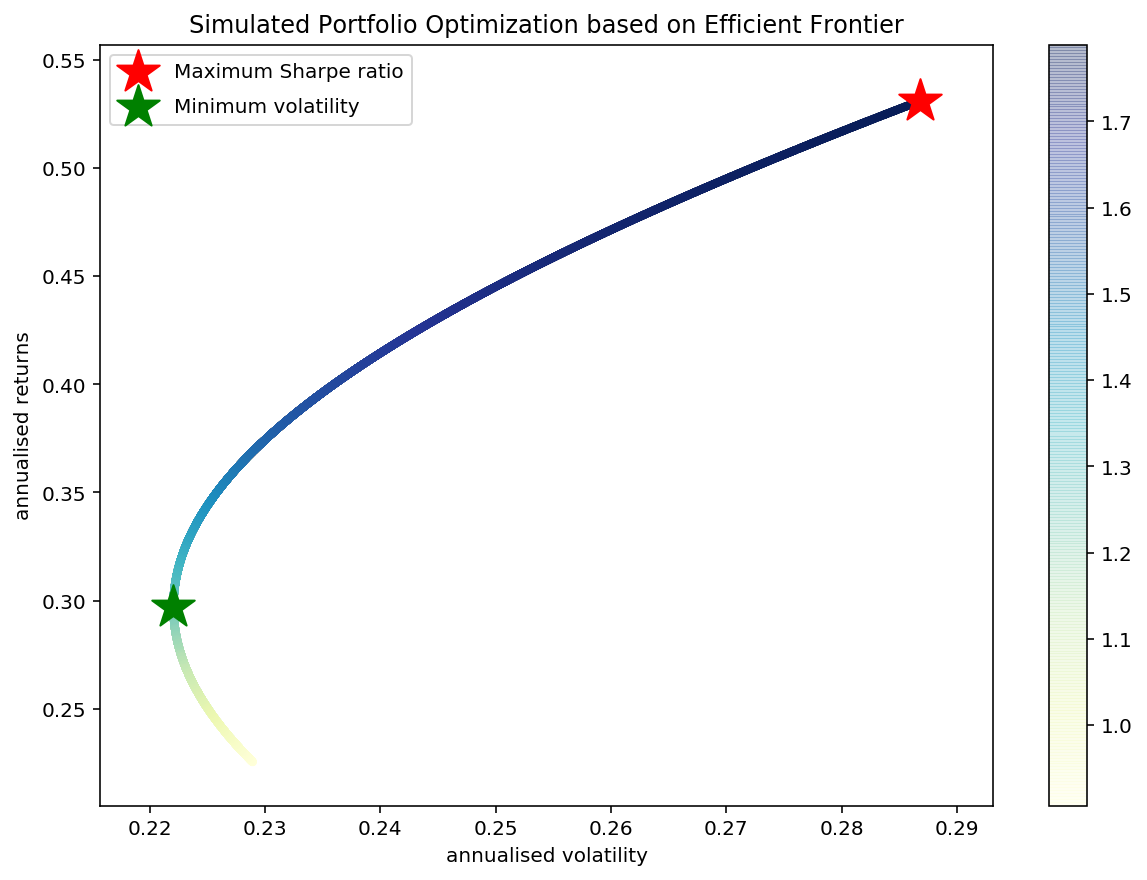

In [13]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

## Efficient Frontier

Can also be implemented using Scipy's optimize function.

"neg_sharpe_ratio" is computed and used as the objective function to minimize.

In [0]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) # sum of all the weights should be equal to 1 
    bound = (0.0,1.0) # any weight should be inclusively between 0 and 1
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

"portfolio_volatility" is computed and used as the objective function to minimize.

In [0]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

"efficient_return" is calculating the most efficient portfolio for a given target return, and the second function "efficient_frontier" will take a range of target returns and compute efficient portfolio for each return level.

In [0]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [0]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print "-"*80
    print "Maximum Sharpe Ratio Portfolio Allocation\n"
    print "Annualised Return:", round(rp,2)
    print "Annualised Volatility:", round(sdp,2)
    print "\n"
    print max_sharpe_allocation
    print "-"*80
    print "Minimum Volatility Portfolio Allocation\n"
    print "Annualised Return:", round(rp_min,2)
    print "Annualised Volatility:", round(sdp_min,2)
    print "\n"
    print min_vol_allocation
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.53
Annualised Volatility: 0.29


             AMZN  GOOGL
allocation  100.0    0.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.3
Annualised Volatility: 0.22


            AMZN  GOOGL
allocation  23.5   76.5


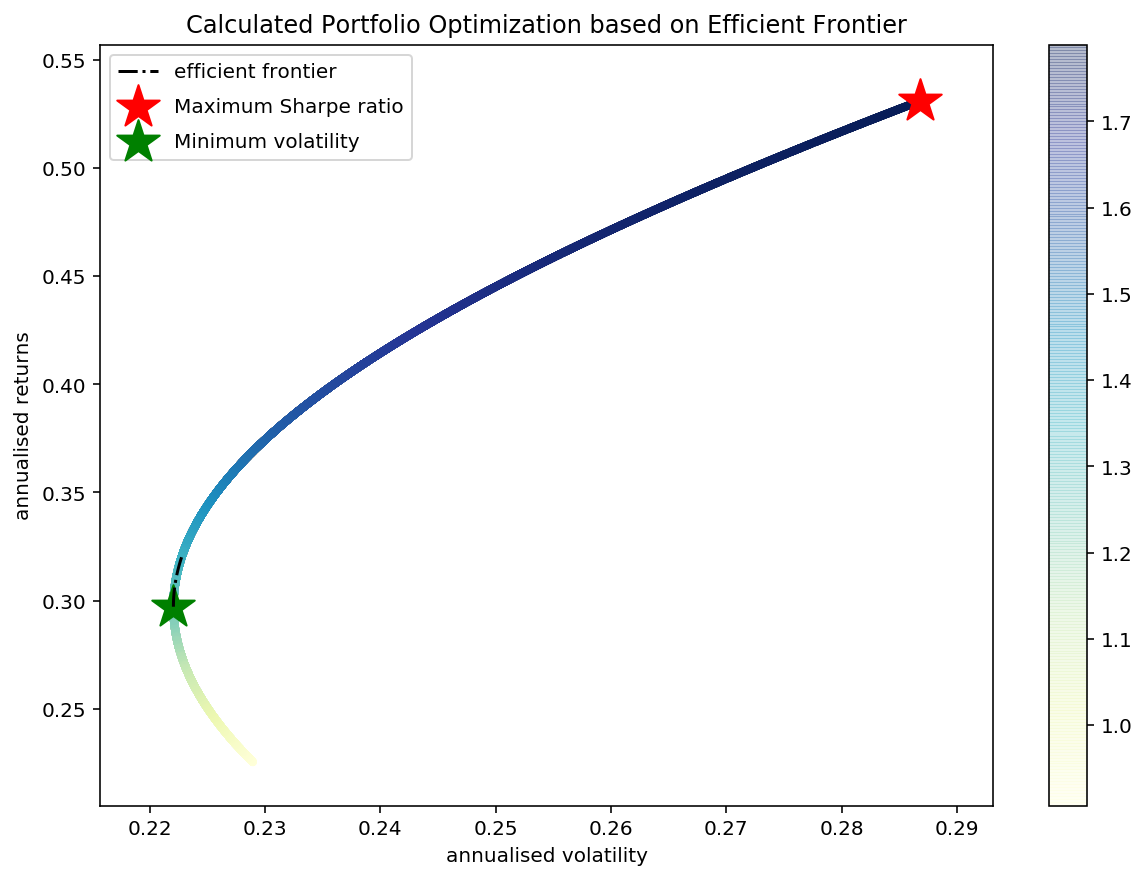

In [18]:
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [0]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    print "-"*80
    print "Maximum Sharpe Ratio Portfolio Allocation\n"
    print "Annualised Return:", round(rp,2)
    print "Annualised Volatility:", round(sdp,2)
    print "\n"
    print max_sharpe_allocation
    print "-"*80
    print "Minimum Volatility Portfolio Allocation\n"
    print "Annualised Return:", round(rp_min,2)
    print "Annualised Volatility:", round(sdp_min,2)
    print "\n"
    print min_vol_allocation
    print "-"*80
    print "Individual Stock Returns and Volatility\n"
    for i, txt in enumerate(table.columns):
        print txt,":","annuaised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2)
    print "-"*80
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(table.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.53
Annualised Volatility: 0.29


             AMZN  GOOGL
allocation  100.0    0.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.3
Annualised Volatility: 0.22


            AMZN  GOOGL
allocation  23.5   76.5
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

AMZN : annuaised return 0.53 , annualised volatility: 0.29
GOOGL : annuaised return 0.23 , annualised volatility: 0.23
--------------------------------------------------------------------------------


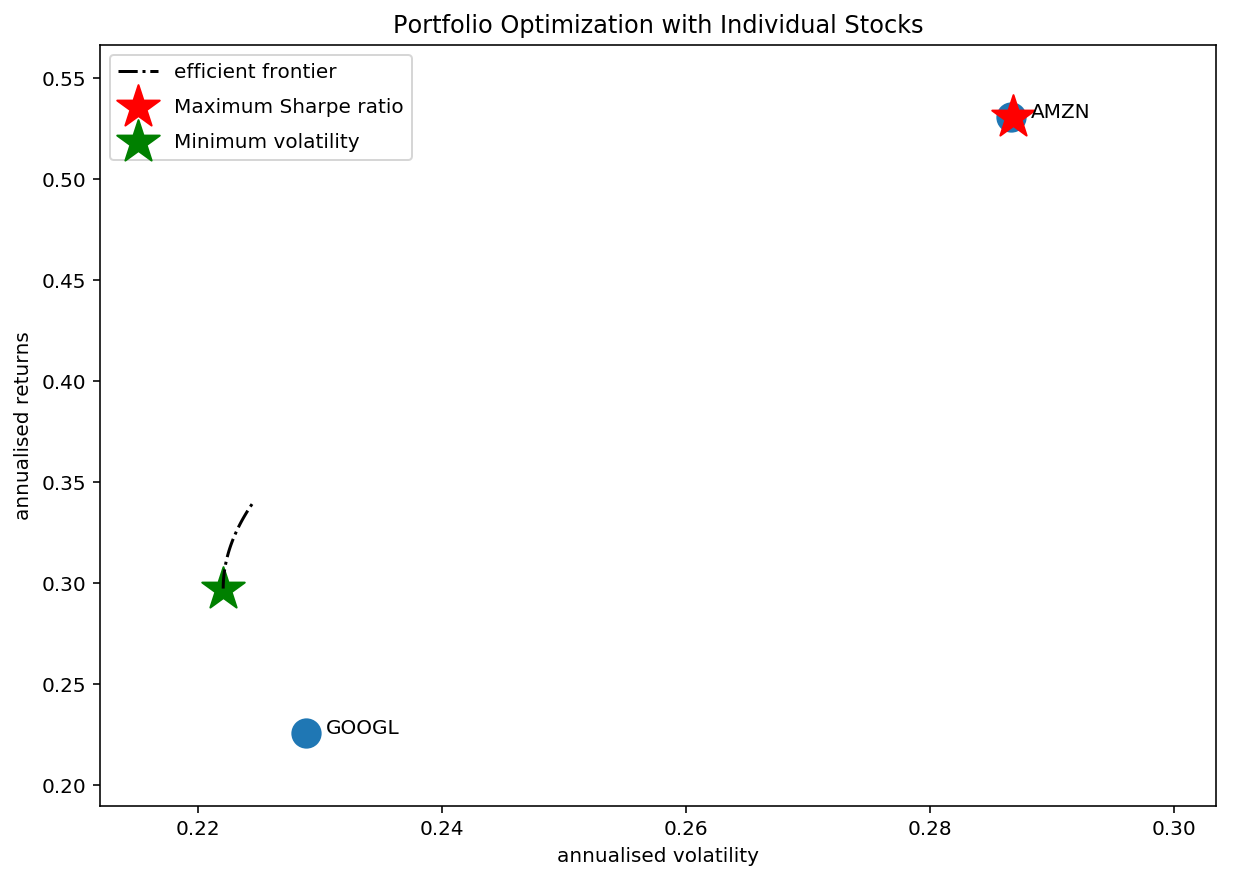

In [20]:
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)